# Object Detection: R-FCN and SSD-MobileNet

This notebook accompanies the tutorial [Object Detection with TensorFlow Serving on CPU](https://github.com/IntelAI/models/tree/master/docs/object_detection/Tutorial.md) and demonstrates the use of the TensorFlow Object Detection API to test and visualize predictions from a R-FCN or SSD-MobileNet SavedModel over gRPC or REST. Please refer to the prerequisites below to set up a model server and suitable client environment before executing this notebook.

## Prerequisites
This notebook assumes you have already:
* [Installed TensorFlow Serving](https://github.com/IntelAI/models/tree/master/docs/general/tensorflow_serving/InstallationGuide.md)
* Read and understood the [General Best Practices](https://github.com/IntelAI/models/tree/master/docs/general/tensorflow_serving/GeneralBestPractices.md#tensorflow-serving-configuration-settings)
* Ran an example end-to-end using a REST or gRPC client, such as the examples in the [Installation Guide](https://github.com/IntelAI/models/tree/master/docs/general/tensorflow_serving/InstallationGuide.md#example-serving-resnet-50-v1-model)
* Ran the hands-on tutorial [Object Detection with TensorFlow Serving on CPU](https://github.com/IntelAI/models/tree/master/docs/object_detection/Tutorial.md) up to the "Visualize object detection output" step

In [1]:
from __future__ import print_function

import os
import time
import random
import numpy as np
import tensorflow as tf
from PIL import Image

from object_detection.utils.visualization_utils import visualize_boxes_and_labels_on_image_array
from object_detection.utils import label_map_util

%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

## Setup
Set global variables, create the COCO label map, and set the server URL

In [2]:
HOST = 'localhost' # Edit this if using a remote host to serve the model
MODEL = 'ssd-mobilenet' # Use 'rfcn' for R-FCN or 'ssd-mobilenet' for SSD-MobileNet
PROTOCOL = 'grpc'  # Use 'grpc' for gRPC or 'rest' for REST
IMAGES_PATH = os.environ['COCO_VAL_DATA'] # Use tutorial env var or edit this to your COCO validation directory
TF_MODELS_PATH = os.environ['TF_MODELS_ROOT'] # Use tutorial env var or edit this to your TensorFlow models directory
LABELS_PATH = os.path.join(TF_MODELS_PATH, 'research', 'object_detection', 'data', 'mscoco_label_map.pbtxt')

In [3]:
label_map = label_map_util.load_labelmap(LABELS_PATH)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=90, use_display_name=True)
CATEGORY_INDEX = label_map_util.create_category_index(categories)

In [4]:
if PROTOCOL == 'grpc':
    import grpc
    import tensorflow as tf
    from tensorflow_serving.apis import predict_pb2
    from tensorflow_serving.apis import prediction_service_pb2_grpc
    SERVER_URL = '{}:8500'.format(HOST)
elif PROTOCOL == 'rest':
    import requests
    SERVER_URL = 'http://{}:8501/v1/models/{}:predict'.format(HOST, MODEL)

Functions for retrieving a random COCO image and visualizing a server response

In [5]:
def get_random_image(image_dir):
    image_path = os.path.join(image_dir, random.choice(os.listdir(image_dir)))
    image = Image.open(image_path)
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def visualize(output_dict, image_np):
    new_dict = {}
    if PROTOCOL == 'grpc':
        new_dict['num_detections'] = int(output_dict['num_detections'].float_val[0])
        new_dict['detection_classes'] = np.array(output_dict['detection_classes'].float_val).astype(np.uint8)
        new_dict['detection_boxes'] = np.array(output_dict['detection_boxes'].float_val).reshape((-1,4))
        new_dict['detection_scores'] = np.array(output_dict['detection_scores'].float_val)
        new_dict['instance_masks'] = np.array(output_dict['instance_masks'].float_val)
    elif PROTOCOL == 'rest':
        new_dict['num_detections'] = int(output_dict['num_detections'])
        new_dict['detection_classes'] = np.array(output_dict['detection_classes']).astype(np.uint8)
        new_dict['detection_boxes'] = np.array(output_dict['detection_boxes'])
        new_dict['detection_scores'] = np.array(output_dict['detection_scores'])

    # Visualize the results of a detection
    visualize_boxes_and_labels_on_image_array(
        image_np,
        new_dict['detection_boxes'],
        new_dict['detection_classes'],
        new_dict['detection_scores'],
        CATEGORY_INDEX,
        instance_masks=None,
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=(20,10))
    plt.imshow(image_np)

## Test Object Detection
Get a random COCO image, send it to the server for prediction, and display the result

In [6]:
batch_size = 1
np_image = get_random_image(IMAGES_PATH)

Requesting prediction using gRPC...


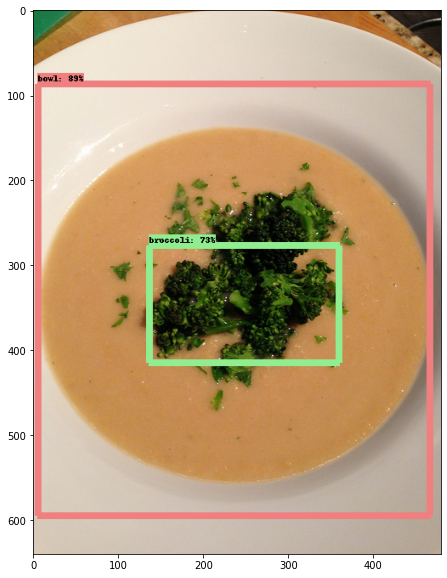

In [7]:
if PROTOCOL == 'grpc':
    print('Requesting prediction using gRPC...')
    np_image = np.repeat(np.expand_dims(np_image, 0), batch_size, axis=0)
    channel = grpc.insecure_channel(SERVER_URL)
    stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
    request = predict_pb2.PredictRequest()
    request.model_spec.name = MODEL
    request.model_spec.signature_name = 'serving_default'
    request.inputs['inputs'].CopyFrom(tf.make_tensor_proto(np_image))
    result = stub.Predict(request)
    visualize(result.outputs, np_image[0])
elif PROTOCOL == 'rest':
    print('Requesting prediction using REST...')
    predict_request = '{"instances" : %s}' % np.expand_dims(np_image, 0).tolist()
    result = requests.post(SERVER_URL, data=predict_request)
    visualize(result.json()['predictions'][0], np_image)

## Measure Performance
Functions for benchmarking online and batch inference

In [8]:
def make_request(batch_size):
    if PROTOCOL == 'rest':
        np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0).tolist(), batch_size, axis=0).tolist()
        return '{"instances" : %s}' % np_images
    elif PROTOCOL == 'grpc':
        np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0), batch_size, axis=0)
        channel = grpc.insecure_channel(SERVER_URL)
        stub = prediction_service_pb2_grpc.PredictionServiceStub(channel)
        request = predict_pb2.PredictRequest()
        request.model_spec.name = MODEL
        request.model_spec.signature_name = 'serving_default'
        request.inputs['inputs'].CopyFrom(tf.make_tensor_proto(np_images))
        return (stub, request)

def send_request(predict_request):
    if PROTOCOL == 'rest':
        requests.post(SERVER_URL, data=predict_request)
    elif PROTOCOL == 'grpc':
        predict_request[0].Predict(predict_request[1])

def benchmark(batch_size=1, num_iteration=10, warm_up_iteration=2):
    i = 0
    total_time = 0
    for _ in range(num_iteration):
        i += 1
        np_images = np.repeat(np.expand_dims(get_random_image(IMAGES_PATH), 0), batch_size, axis=0)
        predict_request = make_request(batch_size)
        start_time = time.time()
        send_request(predict_request)
        time_consume = time.time() - start_time
        print('Iteration %d: %.3f sec' % (i, time_consume))
        if i > warm_up_iteration:
            total_time += time_consume

    time_average = total_time / (num_iteration - warm_up_iteration)
    print('Average time: %.3f sec' % (time_average))
    print('Batch size = %d' % batch_size)
    if batch_size == 1:
        print('Latency: %.3f ms' % (time_average * 1000))
    print('Throughput: %.3f images/sec' % (batch_size / time_average))

## Real-time Inference (latency, batch_size=1)

In [9]:
benchmark()

Iteration 1: 0.033 sec
Iteration 2: 0.032 sec
Iteration 3: 0.028 sec
Iteration 4: 0.041 sec
Iteration 5: 0.054 sec
Iteration 6: 0.027 sec
Iteration 7: 0.027 sec
Iteration 8: 0.026 sec
Iteration 9: 0.027 sec
Iteration 10: 0.026 sec
Average time: 0.032 sec
Batch size = 1
Latency: 31.938 ms
Throughput: 31.311 images/sec


## Throughput (batch_size=128)

In [10]:
benchmark(batch_size=128)

Iteration 1: 2.150 sec
Iteration 2: 2.174 sec
Iteration 3: 2.179 sec
Iteration 4: 2.203 sec
Iteration 5: 2.165 sec
Iteration 6: 2.047 sec
Iteration 7: 2.183 sec
Iteration 8: 2.157 sec
Iteration 9: 2.157 sec
Iteration 10: 2.170 sec
Average time: 2.158 sec
Batch size = 128
Throughput: 59.324 images/sec
